In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib
import matplotlib.pyplot as plt
from pprint import pprint

In [2]:
import sys
sys.path.extend(["../"])
from core.tools.data_import import *
from core.tools.time_series import *
from core.tools.visualize import *
from core.models.baseline_rnn import *
from constants import *

In [3]:
z = np.sin(np.linspace(0, 50, 10000))
z = pd.DataFrame(z)
plt.plot(z)
z.columns = ["sin"]
z.head()

,sin
0,0.000000
1,0.005000
2,0.010001
3,0.015001
4,0.020001


In [4]:
# # Select a source of file.
# pprint(UNRATE_DIR)
# #file_dir_selected = input("Select Directory ")
# file_dir_selected = "GCE"

In [5]:
# Pre-processing Parameters
PERIODS = 1
ORDER = 1
LAGS = 36

In [6]:
df = load_dataset("/home/qinchenwang/AnnEconForecast/data/UNRATE.csv")
prepared_df = differencing(df, periods=PERIODS, order=ORDER)
prepared_df.head()

Dataset loaded.    
	Index type: datetime64[ns]    
	Data type: float64


,UNRATE_period1_order1
DATE,
1948-01-01,NaN
1948-02-01,0.4
1948-03-01,0.2
1948-04-01,-0.1
1948-05-01,-0.4


In [8]:
print(prepared_df)

            UNRATE_period1_order1
DATE                             
1948-01-01                    NaN
1948-02-01                    0.4
1948-03-01                    0.2
1948-04-01                   -0.1
1948-05-01                   -0.4
1948-06-01                    0.1
1948-07-01                    0.0
1948-08-01                    0.3
1948-09-01                   -0.1
1948-10-01                   -0.1
1948-11-01                    0.1
1948-12-01                    0.2
1949-01-01                    0.3
1949-02-01                    0.4
1949-03-01                    0.3
1949-04-01                    0.3
1949-05-01                    0.8
1949-06-01                    0.1
1949-07-01                    0.5
1949-08-01                    0.1
1949-09-01                   -0.2
1949-10-01                    1.3
1949-11-01                   -1.5
1949-12-01                    0.2
1950-01-01                   -0.1
1950-02-01                   -0.1
1950-03-01                   -0.1
1950-04-01    

In [9]:
X_raw, y_raw = gen_supervised_sequence(
    prepared_df, LAGS, prepared_df.columns[0], sequential_label=False)

Total 812 observations generated.
Note: shape format: (num_obs, time_steps, num_inputs/outputs)
X shape = (812, 36, 1), y shape = (812, 1, 1)


In [11]:
print(X_raw.shape)

(812, 36, 1)


In [8]:
# X_raw = X_raw.reshape(-1, LAGS,)
# y_raw = y_raw.reshape(-1, LAGS,)
# print(X_raw.shape, y_raw.shape)

In [9]:
(X_train, X_test,
 y_train, y_test) = train_test_split(
    X_raw, y_raw,
    test_size=0.2,
    shuffle=False
)

(X_train, X_val,
 y_train, y_val) = train_test_split(
    X_train, y_train,
    test_size=0.2,
    shuffle=False
)

In [10]:
# # Expand dimension so it fits the RNN input place holder.
# # (Num_Sample, time_steps, 1)
# X_train = np.expand_dims(X_train, axis=-1)
# X_test = np.expand_dims(X_test, axis=-1)
# X_val = np.expand_dims(X_val, axis=-1)

In [11]:
# y_train = np.expand_dims(y_train, axis=-1)
# y_test = np.expand_dims(y_test, axis=-1)
# y_val = np.expand_dims(y_val, axis=-1)

In [12]:
print(f"Training and testing set generated,\
\nX_train shape: {X_train.shape}\
\ny_train shape: {y_train.shape}\
\nX_test shape: {X_test.shape}\
\ny_test shape: {y_test.shape}\
\nX_validation shape: {X_val.shape}\
\ny_validation shape: {y_val.shape}")

Training and testing set generated,
X_train shape: (519, 36, 1)
y_train shape: (519, 1, 1)
X_test shape: (163, 36, 1)
y_test shape: (163, 1, 1)
X_validation shape: (130, 36, 1)
y_validation shape: (130, 1, 1)


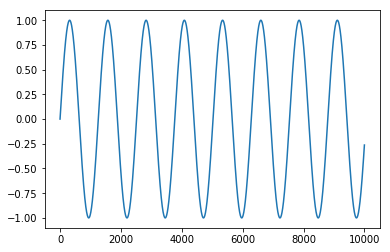

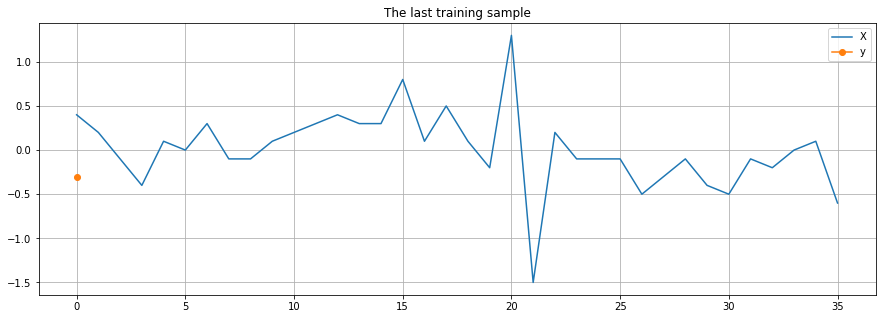

In [13]:
# One Sample
plt.figure(figsize=(15, 5))
plt.title("The last training sample")
plt.plot(X_train[0])
plt.plot(y_train[0], "-o")
plt.legend(["X", "y"])
plt.grid(True)
plt.show()

In [14]:
# Model Parameters
num_time_steps = LAGS
# Number of series used to predict. (including concurrent)
num_inputs = 1
num_outputs = 1
num_neurons = 64
# Number of output series
learning_rate = 0.03
epochs = 1500
# Training Settings
report_periods = epochs // 10

In [15]:
parameters = {
    "num_time_steps": LAGS,
    "num_inputs": 1,
    "num_outputs": 1,
    "num_neurons": 64,
    "learning_rate": 0.003
}

In [16]:
model = BaselineRnn(para=parameters, sequential_label=True)

Model: loading parameters
Building placeholders...
Building core rnn...
Building metrics and operations...


In [17]:
# Inspect Models.
model.learning_rate

0.003

In [18]:
hist = {"train": [], "val": []}

saver = tf.train.Saver()

with tf.Session() as sess:
    sess.run(model.init)
    for e in range(epochs):
        progbar(e, epochs-1, 0)
        sess.run(model.train,
                 feed_dict={model.X: X_train, model.y: y_train})
        if True:
            eval_loss = lambda pred, resp: model.loss.eval(
                feed_dict={model.X: pred, model.y: resp})
            train_mse = eval_loss(X_train, y_train)
            val_mse = eval_loss(X_val, y_val)
            # based on training set
            persist_mse = ((y_train[1:] - y_train[:-1])**2).mean(axis=None)
            hist["train"].append(train_mse)
            hist["val"].append(val_mse)
            print(f"Iteration [{e}], Training MSE {train_mse:0.7f}; Validation MSE {val_mse:0.7f}; Persistence MSE {persist_mse:0.7f}")
    
    if model.SL:
        gen_pred = lambda src: model.outputs.eval(feed_dict={model.X: src})[:,-1]
    else:
        gen_pred = lambda src: model.outputs.eval(feed_dict={model.X: src})
    p_train = gen_pred(X_train)
    p_test = gen_pred(X_test)
    save_path = saver.save(sess, "../model.ckpt")

  [0/1499,   0.00%]Iteration [0], Training MSE 0.0439602; Validation MSE 0.0183182; Persistence MSE 0.0705792
  [1/1499,   0.07%]Iteration [1], Training MSE 0.0437802; Validation MSE 0.0184145; Persistence MSE 0.0705792
  [2/1499,   0.13%]Iteration [2], Training MSE 0.0436691; Validation MSE 0.0185389; Persistence MSE 0.0705792
  [3/1499,   0.20%]Iteration [3], Training MSE 0.0435816; Validation MSE 0.0186447; Persistence MSE 0.0705792
  [4/1499,   0.27%]Iteration [4], Training MSE 0.0434948; Validation MSE 0.0186993; Persistence MSE 0.0705792
  [5/1499,   0.33%]Iteration [5], Training MSE 0.0434146; Validation MSE 0.0186935; Persistence MSE 0.0705792
  [6/1499,   0.40%]Iteration [6], Training MSE 0.0433479; Validation MSE 0.0186825; Persistence MSE 0.0705792
  [7/1499,   0.47%]Iteration [7], Training MSE 0.0432908; Validation MSE 0.0187509; Persistence MSE 0.0705792
  [8/1499,   0.53%]Iteration [8], Training MSE 0.0432561; Validation MSE 0.0189210; Persistence MSE 0.0705792
  [9/1499,

  [74/1499,   4.94%]Iteration [74], Training MSE 0.0424496; Validation MSE 0.0187620; Persistence MSE 0.0705792
  [75/1499,   5.00%]Iteration [75], Training MSE 0.0423595; Validation MSE 0.0187016; Persistence MSE 0.0705792
  [76/1499,   5.07%]Iteration [76], Training MSE 0.0423545; Validation MSE 0.0187171; Persistence MSE 0.0705792
  [77/1499,   5.14%]Iteration [77], Training MSE 0.0423803; Validation MSE 0.0187727; Persistence MSE 0.0705792
  [78/1499,   5.20%]Iteration [78], Training MSE 0.0423443; Validation MSE 0.0189119; Persistence MSE 0.0705792
  [79/1499,   5.27%]Iteration [79], Training MSE 0.0422587; Validation MSE 0.0191468; Persistence MSE 0.0705792
  [80/1499,   5.34%]Iteration [80], Training MSE 0.0421826; Validation MSE 0.0194019; Persistence MSE 0.0705792
  [81/1499,   5.40%]Iteration [81], Training MSE 0.0421218; Validation MSE 0.0195263; Persistence MSE 0.0705792
  [82/1499,   5.47%]Iteration [82], Training MSE 0.0420738; Validation MSE 0.0194013; Persistence MSE 0.

  [147/1499,   9.81%]Iteration [147], Training MSE 0.0431342; Validation MSE 0.0192174; Persistence MSE 0.0705792
  [148/1499,   9.87%]Iteration [148], Training MSE 0.0430818; Validation MSE 0.0191246; Persistence MSE 0.0705792
  [149/1499,   9.94%]Iteration [149], Training MSE 0.0430284; Validation MSE 0.0190107; Persistence MSE 0.0705792
  [150/1499,  10.01%]Iteration [150], Training MSE 0.0429778; Validation MSE 0.0188902; Persistence MSE 0.0705792
  [151/1499,  10.07%]Iteration [151], Training MSE 0.0429312; Validation MSE 0.0187655; Persistence MSE 0.0705792
  [152/1499,  10.14%]Iteration [152], Training MSE 0.0428925; Validation MSE 0.0186500; Persistence MSE 0.0705792
  [153/1499,  10.21%]Iteration [153], Training MSE 0.0428563; Validation MSE 0.0185635; Persistence MSE 0.0705792
  [154/1499,  10.27%]Iteration [154], Training MSE 0.0428114; Validation MSE 0.0185133; Persistence MSE 0.0705792
  [155/1499,  10.34%]Iteration [155], Training MSE 0.0427650; Validation MSE 0.0185029; 

  [219/1499,  14.61%]Iteration [219], Training MSE 0.0411543; Validation MSE 0.0192494; Persistence MSE 0.0705792
  [220/1499,  14.68%]Iteration [220], Training MSE 0.0411997; Validation MSE 0.0192284; Persistence MSE 0.0705792
  [221/1499,  14.74%]Iteration [221], Training MSE 0.0414041; Validation MSE 0.0192366; Persistence MSE 0.0705792
  [222/1499,  14.81%]Iteration [222], Training MSE 0.0413460; Validation MSE 0.0191700; Persistence MSE 0.0705792
  [223/1499,  14.88%]Iteration [223], Training MSE 0.0411283; Validation MSE 0.0191603; Persistence MSE 0.0705792
  [224/1499,  14.94%]Iteration [224], Training MSE 0.0411671; Validation MSE 0.0191363; Persistence MSE 0.0705792
  [225/1499,  15.01%]Iteration [225], Training MSE 0.0411090; Validation MSE 0.0191915; Persistence MSE 0.0705792
  [226/1499,  15.08%]Iteration [226], Training MSE 0.0410784; Validation MSE 0.0192363; Persistence MSE 0.0705792
  [227/1499,  15.14%]Iteration [227], Training MSE 0.0412397; Validation MSE 0.0192120; 

  [291/1499,  19.41%]Iteration [291], Training MSE 0.0397714; Validation MSE 0.0196508; Persistence MSE 0.0705792
  [292/1499,  19.48%]Iteration [292], Training MSE 0.0397098; Validation MSE 0.0197079; Persistence MSE 0.0705792
  [293/1499,  19.55%]Iteration [293], Training MSE 0.0399503; Validation MSE 0.0187559; Persistence MSE 0.0705792
  [294/1499,  19.61%]Iteration [294], Training MSE 0.0396118; Validation MSE 0.0191431; Persistence MSE 0.0705792
  [295/1499,  19.68%]Iteration [295], Training MSE 0.0398745; Validation MSE 0.0200818; Persistence MSE 0.0705792
  [296/1499,  19.75%]Iteration [296], Training MSE 0.0399203; Validation MSE 0.0193723; Persistence MSE 0.0705792
  [297/1499,  19.81%]Iteration [297], Training MSE 0.0393346; Validation MSE 0.0196228; Persistence MSE 0.0705792
  [298/1499,  19.88%]Iteration [298], Training MSE 0.0392925; Validation MSE 0.0192972; Persistence MSE 0.0705792
  [299/1499,  19.95%]Iteration [299], Training MSE 0.0392618; Validation MSE 0.0193837; 

  [363/1499,  24.22%]Iteration [363], Training MSE 0.0375540; Validation MSE 0.0194085; Persistence MSE 0.0705792
  [364/1499,  24.28%]Iteration [364], Training MSE 0.0383462; Validation MSE 0.0207937; Persistence MSE 0.0705792
  [365/1499,  24.35%]Iteration [365], Training MSE 0.0370892; Validation MSE 0.0199021; Persistence MSE 0.0705792
  [366/1499,  24.42%]Iteration [366], Training MSE 0.0378039; Validation MSE 0.0192398; Persistence MSE 0.0705792
  [367/1499,  24.48%]Iteration [367], Training MSE 0.0370019; Validation MSE 0.0204339; Persistence MSE 0.0705792
  [368/1499,  24.55%]Iteration [368], Training MSE 0.0375083; Validation MSE 0.0221411; Persistence MSE 0.0705792
  [369/1499,  24.62%]Iteration [369], Training MSE 0.0368556; Validation MSE 0.0195150; Persistence MSE 0.0705792
  [370/1499,  24.68%]Iteration [370], Training MSE 0.0376328; Validation MSE 0.0186035; Persistence MSE 0.0705792
  [371/1499,  24.75%]Iteration [371], Training MSE 0.0369362; Validation MSE 0.0190575; 

  [435/1499,  29.02%]Iteration [435], Training MSE 0.0341078; Validation MSE 0.0212092; Persistence MSE 0.0705792
  [436/1499,  29.09%]Iteration [436], Training MSE 0.0346226; Validation MSE 0.0230548; Persistence MSE 0.0705792
  [437/1499,  29.15%]Iteration [437], Training MSE 0.0343834; Validation MSE 0.0194069; Persistence MSE 0.0705792
  [438/1499,  29.22%]Iteration [438], Training MSE 0.0336743; Validation MSE 0.0214477; Persistence MSE 0.0705792
  [439/1499,  29.29%]Iteration [439], Training MSE 0.0339282; Validation MSE 0.0215829; Persistence MSE 0.0705792
  [440/1499,  29.35%]Iteration [440], Training MSE 0.0338729; Validation MSE 0.0190061; Persistence MSE 0.0705792
  [441/1499,  29.42%]Iteration [441], Training MSE 0.0335405; Validation MSE 0.0200445; Persistence MSE 0.0705792
  [442/1499,  29.49%]Iteration [442], Training MSE 0.0337716; Validation MSE 0.0217217; Persistence MSE 0.0705792
  [443/1499,  29.55%]Iteration [443], Training MSE 0.0335799; Validation MSE 0.0203758; 

  [507/1499,  33.82%]Iteration [507], Training MSE 0.0310342; Validation MSE 0.0209592; Persistence MSE 0.0705792
  [508/1499,  33.89%]Iteration [508], Training MSE 0.0311193; Validation MSE 0.0200371; Persistence MSE 0.0705792
  [509/1499,  33.96%]Iteration [509], Training MSE 0.0309267; Validation MSE 0.0200587; Persistence MSE 0.0705792
  [510/1499,  34.02%]Iteration [510], Training MSE 0.0307450; Validation MSE 0.0206945; Persistence MSE 0.0705792
  [511/1499,  34.09%]Iteration [511], Training MSE 0.0307171; Validation MSE 0.0203401; Persistence MSE 0.0705792
  [512/1499,  34.16%]Iteration [512], Training MSE 0.0306710; Validation MSE 0.0208590; Persistence MSE 0.0705792
  [513/1499,  34.22%]Iteration [513], Training MSE 0.0306455; Validation MSE 0.0206768; Persistence MSE 0.0705792
  [514/1499,  34.29%]Iteration [514], Training MSE 0.0304461; Validation MSE 0.0202042; Persistence MSE 0.0705792
  [515/1499,  34.36%]Iteration [515], Training MSE 0.0307577; Validation MSE 0.0211936; 

  [579/1499,  38.63%]Iteration [579], Training MSE 0.0289192; Validation MSE 0.0210112; Persistence MSE 0.0705792
  [580/1499,  38.69%]Iteration [580], Training MSE 0.0283579; Validation MSE 0.0203523; Persistence MSE 0.0705792
  [581/1499,  38.76%]Iteration [581], Training MSE 0.0292037; Validation MSE 0.0191862; Persistence MSE 0.0705792
  [582/1499,  38.83%]Iteration [582], Training MSE 0.0281595; Validation MSE 0.0202866; Persistence MSE 0.0705792
  [583/1499,  38.89%]Iteration [583], Training MSE 0.0286017; Validation MSE 0.0223470; Persistence MSE 0.0705792
  [584/1499,  38.96%]Iteration [584], Training MSE 0.0287159; Validation MSE 0.0198525; Persistence MSE 0.0705792
  [585/1499,  39.03%]Iteration [585], Training MSE 0.0283800; Validation MSE 0.0206221; Persistence MSE 0.0705792
  [586/1499,  39.09%]Iteration [586], Training MSE 0.0289193; Validation MSE 0.0238265; Persistence MSE 0.0705792
  [587/1499,  39.16%]Iteration [587], Training MSE 0.0279708; Validation MSE 0.0204396; 

  [651/1499,  43.43%]Iteration [651], Training MSE 0.0250013; Validation MSE 0.0274446; Persistence MSE 0.0705792
  [652/1499,  43.50%]Iteration [652], Training MSE 0.0250165; Validation MSE 0.0325934; Persistence MSE 0.0705792
  [653/1499,  43.56%]Iteration [653], Training MSE 0.0250401; Validation MSE 0.0275040; Persistence MSE 0.0705792
  [654/1499,  43.63%]Iteration [654], Training MSE 0.0249219; Validation MSE 0.0322804; Persistence MSE 0.0705792
  [655/1499,  43.70%]Iteration [655], Training MSE 0.0249192; Validation MSE 0.0241935; Persistence MSE 0.0705792
  [656/1499,  43.76%]Iteration [656], Training MSE 0.0246911; Validation MSE 0.0281211; Persistence MSE 0.0705792
  [657/1499,  43.83%]Iteration [657], Training MSE 0.0248708; Validation MSE 0.0341370; Persistence MSE 0.0705792
  [658/1499,  43.90%]Iteration [658], Training MSE 0.0248727; Validation MSE 0.0235573; Persistence MSE 0.0705792
  [659/1499,  43.96%]Iteration [659], Training MSE 0.0246974; Validation MSE 0.0238168; 

  [723/1499,  48.23%]Iteration [723], Training MSE 0.0238795; Validation MSE 0.0438535; Persistence MSE 0.0705792
  [724/1499,  48.30%]Iteration [724], Training MSE 0.0265138; Validation MSE 0.0194922; Persistence MSE 0.0705792
  [725/1499,  48.37%]Iteration [725], Training MSE 0.0245258; Validation MSE 0.0211231; Persistence MSE 0.0705792
  [726/1499,  48.43%]Iteration [726], Training MSE 0.0239493; Validation MSE 0.0348110; Persistence MSE 0.0705792
  [727/1499,  48.50%]Iteration [727], Training MSE 0.0256009; Validation MSE 0.0321752; Persistence MSE 0.0705792
  [728/1499,  48.57%]Iteration [728], Training MSE 0.0237288; Validation MSE 0.0494865; Persistence MSE 0.0705792
  [729/1499,  48.63%]Iteration [729], Training MSE 0.0244436; Validation MSE 0.0219027; Persistence MSE 0.0705792
  [730/1499,  48.70%]Iteration [730], Training MSE 0.0241794; Validation MSE 0.0190846; Persistence MSE 0.0705792
  [731/1499,  48.77%]Iteration [731], Training MSE 0.0239385; Validation MSE 0.0225708; 

  [795/1499,  53.04%]Iteration [795], Training MSE 0.0241653; Validation MSE 0.0199427; Persistence MSE 0.0705792
  [796/1499,  53.10%]Iteration [796], Training MSE 0.0241953; Validation MSE 0.0198398; Persistence MSE 0.0705792
  [797/1499,  53.17%]Iteration [797], Training MSE 0.0237566; Validation MSE 0.0231195; Persistence MSE 0.0705792
  [798/1499,  53.24%]Iteration [798], Training MSE 0.0241203; Validation MSE 0.0285477; Persistence MSE 0.0705792
  [799/1499,  53.30%]Iteration [799], Training MSE 0.0236756; Validation MSE 0.0221836; Persistence MSE 0.0705792
  [800/1499,  53.37%]Iteration [800], Training MSE 0.0236268; Validation MSE 0.0216037; Persistence MSE 0.0705792
  [801/1499,  53.44%]Iteration [801], Training MSE 0.0236543; Validation MSE 0.0255500; Persistence MSE 0.0705792
  [802/1499,  53.50%]Iteration [802], Training MSE 0.0231506; Validation MSE 0.0243893; Persistence MSE 0.0705792
  [803/1499,  53.57%]Iteration [803], Training MSE 0.0234019; Validation MSE 0.0224441; 

  [867/1499,  57.84%]Iteration [867], Training MSE 0.0208536; Validation MSE 0.0331003; Persistence MSE 0.0705792
  [868/1499,  57.91%]Iteration [868], Training MSE 0.0207458; Validation MSE 0.0317057; Persistence MSE 0.0705792
  [869/1499,  57.97%]Iteration [869], Training MSE 0.0207833; Validation MSE 0.0304260; Persistence MSE 0.0705792
  [870/1499,  58.04%]Iteration [870], Training MSE 0.0207342; Validation MSE 0.0296900; Persistence MSE 0.0705792
  [871/1499,  58.11%]Iteration [871], Training MSE 0.0207864; Validation MSE 0.0393154; Persistence MSE 0.0705792
  [872/1499,  58.17%]Iteration [872], Training MSE 0.0208422; Validation MSE 0.0286272; Persistence MSE 0.0705792
  [873/1499,  58.24%]Iteration [873], Training MSE 0.0209452; Validation MSE 0.0346689; Persistence MSE 0.0705792
  [874/1499,  58.31%]Iteration [874], Training MSE 0.0206003; Validation MSE 0.0305050; Persistence MSE 0.0705792
  [875/1499,  58.37%]Iteration [875], Training MSE 0.0205806; Validation MSE 0.0346563; 

  [939/1499,  62.64%]Iteration [939], Training MSE 0.0214657; Validation MSE 0.0266041; Persistence MSE 0.0705792
  [940/1499,  62.71%]Iteration [940], Training MSE 0.0203286; Validation MSE 0.0320361; Persistence MSE 0.0705792
  [941/1499,  62.78%]Iteration [941], Training MSE 0.0199535; Validation MSE 0.0335484; Persistence MSE 0.0705792
  [942/1499,  62.84%]Iteration [942], Training MSE 0.0208405; Validation MSE 0.0304387; Persistence MSE 0.0705792
  [943/1499,  62.91%]Iteration [943], Training MSE 0.0199329; Validation MSE 0.0451035; Persistence MSE 0.0705792
  [944/1499,  62.98%]Iteration [944], Training MSE 0.0201119; Validation MSE 0.0331153; Persistence MSE 0.0705792
  [945/1499,  63.04%]Iteration [945], Training MSE 0.0203736; Validation MSE 0.0254419; Persistence MSE 0.0705792
  [946/1499,  63.11%]Iteration [946], Training MSE 0.0196552; Validation MSE 0.0354179; Persistence MSE 0.0705792
  [947/1499,  63.18%]Iteration [947], Training MSE 0.0208604; Validation MSE 0.0535971; 

  [1011/1499,  67.44%]Iteration [1011], Training MSE 0.0206036; Validation MSE 0.0247064; Persistence MSE 0.0705792
  [1012/1499,  67.51%]Iteration [1012], Training MSE 0.0199257; Validation MSE 0.0257176; Persistence MSE 0.0705792
  [1013/1499,  67.58%]Iteration [1013], Training MSE 0.0210677; Validation MSE 0.0456216; Persistence MSE 0.0705792
  [1014/1499,  67.65%]Iteration [1014], Training MSE 0.0194820; Validation MSE 0.0313026; Persistence MSE 0.0705792
  [1015/1499,  67.71%]Iteration [1015], Training MSE 0.0196840; Validation MSE 0.0313032; Persistence MSE 0.0705792
  [1016/1499,  67.78%]Iteration [1016], Training MSE 0.0203153; Validation MSE 0.0416550; Persistence MSE 0.0705792
  [1017/1499,  67.85%]Iteration [1017], Training MSE 0.0189463; Validation MSE 0.0337347; Persistence MSE 0.0705792
  [1018/1499,  67.91%]Iteration [1018], Training MSE 0.0198391; Validation MSE 0.0346782; Persistence MSE 0.0705792
  [1019/1499,  67.98%]Iteration [1019], Training MSE 0.0193519; Validati

  [1082/1499,  72.18%]Iteration [1082], Training MSE 0.0187080; Validation MSE 0.0301796; Persistence MSE 0.0705792
  [1083/1499,  72.25%]Iteration [1083], Training MSE 0.0185184; Validation MSE 0.0300500; Persistence MSE 0.0705792
  [1084/1499,  72.31%]Iteration [1084], Training MSE 0.0181528; Validation MSE 0.0393854; Persistence MSE 0.0705792
  [1085/1499,  72.38%]Iteration [1085], Training MSE 0.0187602; Validation MSE 0.0462861; Persistence MSE 0.0705792
  [1086/1499,  72.45%]Iteration [1086], Training MSE 0.0180804; Validation MSE 0.0346508; Persistence MSE 0.0705792
  [1087/1499,  72.52%]Iteration [1087], Training MSE 0.0180776; Validation MSE 0.0315164; Persistence MSE 0.0705792
  [1088/1499,  72.58%]Iteration [1088], Training MSE 0.0179952; Validation MSE 0.0349809; Persistence MSE 0.0705792
  [1089/1499,  72.65%]Iteration [1089], Training MSE 0.0180516; Validation MSE 0.0442721; Persistence MSE 0.0705792
  [1090/1499,  72.72%]Iteration [1090], Training MSE 0.0179178; Validati

  [1153/1499,  76.92%]Iteration [1153], Training MSE 0.0166986; Validation MSE 0.0373280; Persistence MSE 0.0705792
  [1154/1499,  76.98%]Iteration [1154], Training MSE 0.0166570; Validation MSE 0.0388434; Persistence MSE 0.0705792
  [1155/1499,  77.05%]Iteration [1155], Training MSE 0.0166085; Validation MSE 0.0402001; Persistence MSE 0.0705792
  [1156/1499,  77.12%]Iteration [1156], Training MSE 0.0166132; Validation MSE 0.0412806; Persistence MSE 0.0705792
  [1157/1499,  77.18%]Iteration [1157], Training MSE 0.0166162; Validation MSE 0.0403413; Persistence MSE 0.0705792
  [1158/1499,  77.25%]Iteration [1158], Training MSE 0.0166873; Validation MSE 0.0365713; Persistence MSE 0.0705792
  [1159/1499,  77.32%]Iteration [1159], Training MSE 0.0169392; Validation MSE 0.0432900; Persistence MSE 0.0705792
  [1160/1499,  77.38%]Iteration [1160], Training MSE 0.0170017; Validation MSE 0.0351408; Persistence MSE 0.0705792
  [1161/1499,  77.45%]Iteration [1161], Training MSE 0.0188326; Validati

  [1224/1499,  81.65%]Iteration [1224], Training MSE 0.0161379; Validation MSE 0.0404277; Persistence MSE 0.0705792
  [1225/1499,  81.72%]Iteration [1225], Training MSE 0.0160926; Validation MSE 0.0409698; Persistence MSE 0.0705792
  [1226/1499,  81.79%]Iteration [1226], Training MSE 0.0161139; Validation MSE 0.0402944; Persistence MSE 0.0705792
  [1227/1499,  81.85%]Iteration [1227], Training MSE 0.0162080; Validation MSE 0.0431814; Persistence MSE 0.0705792
  [1228/1499,  81.92%]Iteration [1228], Training MSE 0.0162657; Validation MSE 0.0379763; Persistence MSE 0.0705792
  [1229/1499,  81.99%]Iteration [1229], Training MSE 0.0166512; Validation MSE 0.0449962; Persistence MSE 0.0705792
  [1230/1499,  82.05%]Iteration [1230], Training MSE 0.0163951; Validation MSE 0.0375028; Persistence MSE 0.0705792
  [1231/1499,  82.12%]Iteration [1231], Training MSE 0.0160657; Validation MSE 0.0418511; Persistence MSE 0.0705792
  [1232/1499,  82.19%]Iteration [1232], Training MSE 0.0161233; Validati

  [1295/1499,  86.39%]Iteration [1295], Training MSE 0.0159617; Validation MSE 0.0463237; Persistence MSE 0.0705792
  [1296/1499,  86.46%]Iteration [1296], Training MSE 0.0157682; Validation MSE 0.0404729; Persistence MSE 0.0705792
  [1297/1499,  86.52%]Iteration [1297], Training MSE 0.0158241; Validation MSE 0.0377329; Persistence MSE 0.0705792
  [1298/1499,  86.59%]Iteration [1298], Training MSE 0.0158083; Validation MSE 0.0414148; Persistence MSE 0.0705792
  [1299/1499,  86.66%]Iteration [1299], Training MSE 0.0155237; Validation MSE 0.0418791; Persistence MSE 0.0705792
  [1300/1499,  86.72%]Iteration [1300], Training MSE 0.0156939; Validation MSE 0.0417557; Persistence MSE 0.0705792
  [1301/1499,  86.79%]Iteration [1301], Training MSE 0.0155267; Validation MSE 0.0439343; Persistence MSE 0.0705792
  [1302/1499,  86.86%]Iteration [1302], Training MSE 0.0155273; Validation MSE 0.0418473; Persistence MSE 0.0705792
  [1303/1499,  86.92%]Iteration [1303], Training MSE 0.0154725; Validati

  [1366/1499,  91.13%]Iteration [1366], Training MSE 0.0150412; Validation MSE 0.0405781; Persistence MSE 0.0705792
  [1367/1499,  91.19%]Iteration [1367], Training MSE 0.0152503; Validation MSE 0.0431088; Persistence MSE 0.0705792
  [1368/1499,  91.26%]Iteration [1368], Training MSE 0.0151915; Validation MSE 0.0397660; Persistence MSE 0.0705792
  [1369/1499,  91.33%]Iteration [1369], Training MSE 0.0149614; Validation MSE 0.0416063; Persistence MSE 0.0705792
  [1370/1499,  91.39%]Iteration [1370], Training MSE 0.0152472; Validation MSE 0.0453100; Persistence MSE 0.0705792
  [1371/1499,  91.46%]Iteration [1371], Training MSE 0.0151826; Validation MSE 0.0386556; Persistence MSE 0.0705792
  [1372/1499,  91.53%]Iteration [1372], Training MSE 0.0149393; Validation MSE 0.0417916; Persistence MSE 0.0705792
  [1373/1499,  91.59%]Iteration [1373], Training MSE 0.0151386; Validation MSE 0.0458493; Persistence MSE 0.0705792
  [1374/1499,  91.66%]Iteration [1374], Training MSE 0.0151098; Validati

  [1437/1499,  95.86%]Iteration [1437], Training MSE 0.0156601; Validation MSE 0.0496953; Persistence MSE 0.0705792
  [1438/1499,  95.93%]Iteration [1438], Training MSE 0.0148801; Validation MSE 0.0385994; Persistence MSE 0.0705792
  [1439/1499,  96.00%]Iteration [1439], Training MSE 0.0154344; Validation MSE 0.0328811; Persistence MSE 0.0705792
  [1440/1499,  96.06%]Iteration [1440], Training MSE 0.0151711; Validation MSE 0.0363748; Persistence MSE 0.0705792
  [1441/1499,  96.13%]Iteration [1441], Training MSE 0.0150067; Validation MSE 0.0507288; Persistence MSE 0.0705792
  [1442/1499,  96.20%]Iteration [1442], Training MSE 0.0147273; Validation MSE 0.0474200; Persistence MSE 0.0705792
  [1443/1499,  96.26%]Iteration [1443], Training MSE 0.0148142; Validation MSE 0.0387243; Persistence MSE 0.0705792
  [1444/1499,  96.33%]Iteration [1444], Training MSE 0.0148377; Validation MSE 0.0382051; Persistence MSE 0.0705792
  [1445/1499,  96.40%]Iteration [1445], Training MSE 0.0146168; Validati

In [12]:
# Visualize testing set result
plt.close()
plt.figure(figsize=(32,16))
plt.title("Testing Set Result")
if model.SL:
    plt.errorbar(range(len(p_test[:,-1])), p_test[:,-1], marker='o')
    plt.errorbar(range(len(y_test[:,-1])), y_test[:,-1], marker='o')
#     plt.plot(np.squeeze(p_test[:,-1]))
#     plt.plot(np.squeeze(y_test[:,-1]))
else:
    plt.plot(np.squeeze(p_test))
    plt.plot(np.squeeze(y_test))
plt.legend(["Test Prediction", "Test Actual"])
plt.grid(True)
plt.show()

NameError: name 'model' is not defined

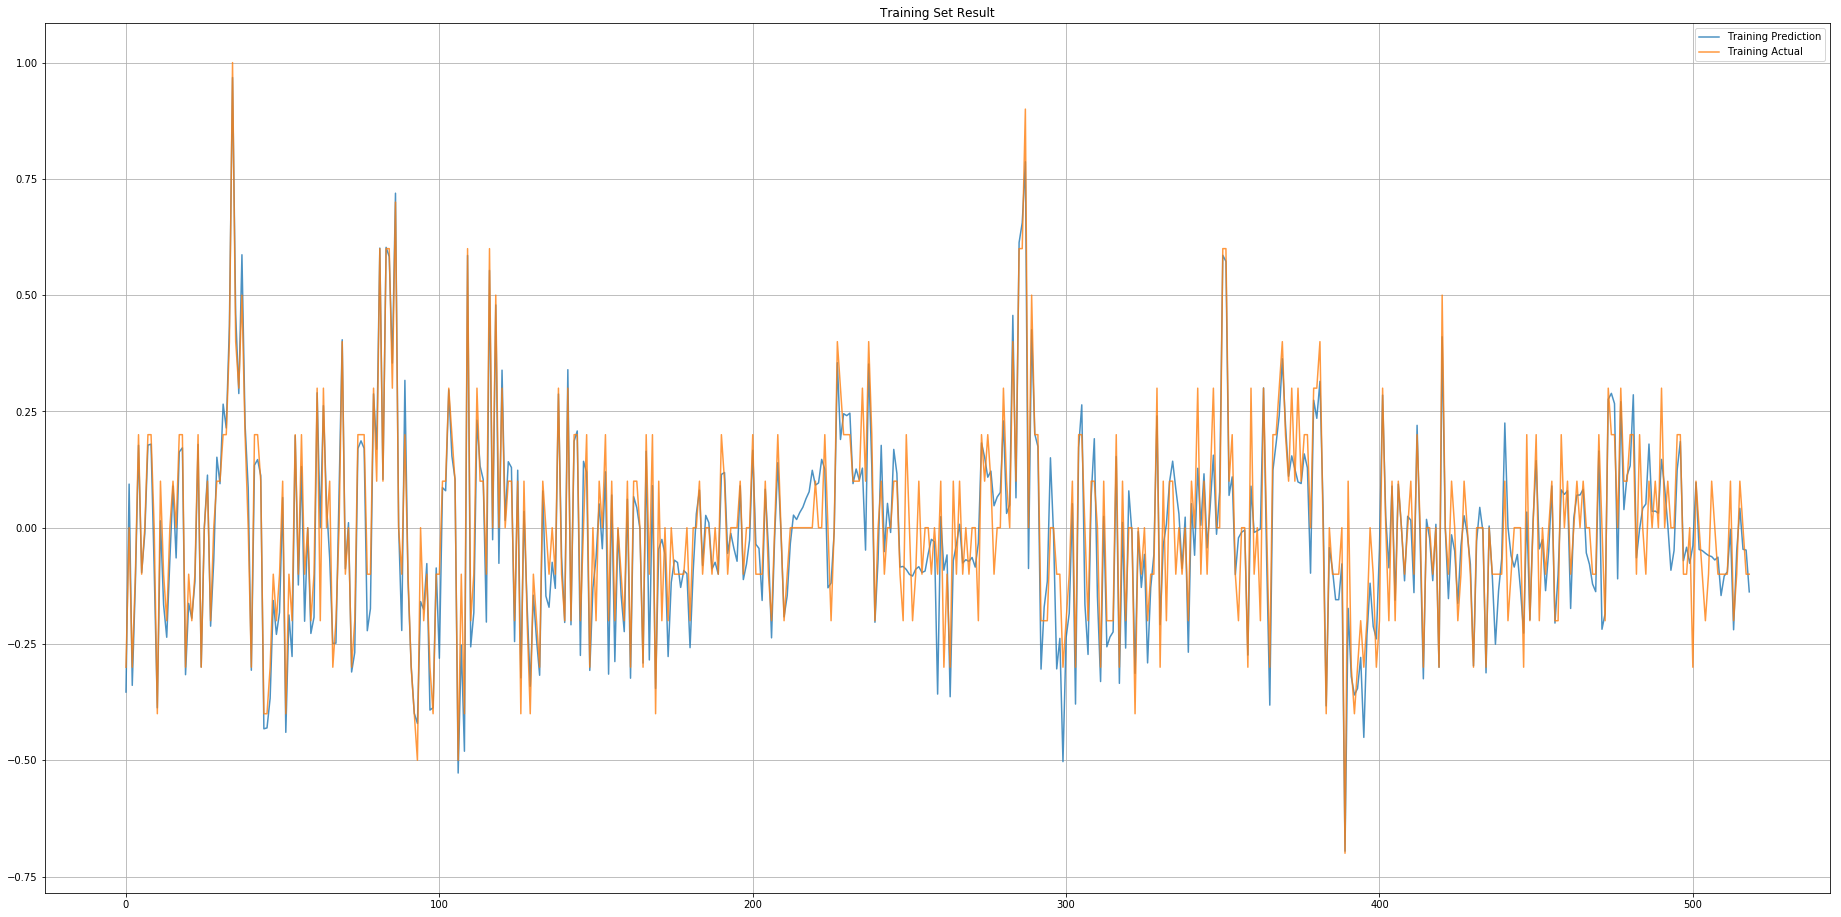

In [20]:
# Visualize training set result
plt.close()
plt.figure(figsize=(32,16))
plt.title("Training Set Result")
if model.SL:
    plt.plot(np.squeeze(p_train[:,-1]), alpha=0.8)
    plt.plot(np.squeeze(y_train[:,-1]), alpha=0.8)
else:
    plt.plot(np.squeeze(p_train), alpha=0.8)
    plt.plot(np.squeeze(y_train), alpha=0.8)
plt.legend(["Training Prediction", "Training Actual"])
plt.grid(True)
plt.show()

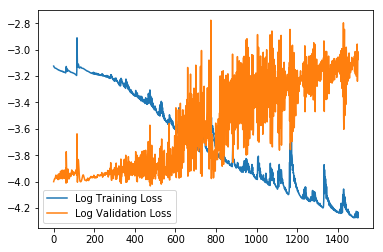

In [21]:
plt.close()
plt.plot(np.log(hist["train"]))
plt.plot(np.log(hist["val"]))
plt.legend(["Log Training Loss", "Log Validation Loss"])
plt.show()

In [ ]:
# start with initial credibility
cred = 1000
for i in range(len(y_raw)):
    if y_raw[i][0] * pred[i][0] >= 0:
        # predicted the same sign
        cred += 1
    else:
        cred -= 1
print(cred)